# Boxplot of top five up- and downregulated genes

In [1]:
library(ggpubr)
library(ggsignif)
library(tidyverse)

Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Functions

In [2]:
add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
    as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
    dplyr::ungroup() %>%
    mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}

save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

## All genes

### Differential expressed genes

In [3]:
genes = read.delim('../../_m/genes/diffExpr_szVctl_full.txt')
genes = genes %>% filter(adj.P.Val < 0.05) %>%  
            select(gencodeID, ensemblID, Symbol, logFC, t, adj.P.Val)
genes = add_symnum(genes)

up_genes = genes %>% filter(t > 0) %>% mutate('Direction'='Up') %>% head(5) 
down_genes = genes %>% filter(t < 0) %>% mutate('Direction'='Down') %>% head(5) 

sig_genes = bind_rows(up_genes, down_genes) %>% mutate_at(vars(Direction), as.factor)

for(xx in seq_along(sig_genes$Symbol)){
    sig_genes$New_ID[xx] <- ifelse(sig_genes$Symbol[xx] == '', 
                                   as.character(sig_genes$ensemblID[xx]), 
                                   as.character(sig_genes$Symbol[xx]))
}
sig_genes

gencodeID,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,Direction,New_ID
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>
ENSG00000248587.7,ENSG00000248587,GDNF-AS1,0.8015019,12.696887,1.387742e-26,< 2e-16,****,Up,GDNF-AS1
ENSG00000138944.7,ENSG00000138944,KIAA1644,0.5637328,12.073351,1.707516e-24,< 2e-16,****,Up,KIAA1644
ENSG00000185052.11,ENSG00000185052,SLC24A3,0.2917627,11.122852,3.972599e-21,< 2e-16,****,Up,SLC24A3
ENSG00000140015.19,ENSG00000140015,KCNH5,0.5156546,10.185331,6.716497e-18,< 2e-16,****,Up,KCNH5
ENSG00000171004.17,ENSG00000171004,HS6ST2,0.3021052,9.670025,3.196203e-16,3.2e-16,****,Up,HS6ST2
ENSG00000180176.14,ENSG00000180176,TH,-0.7962020,-8.362986,1.890708e-12,1.9e-12,****,Down,TH
ENSG00000182674.5,ENSG00000182674,KCNB2,-0.2712236,-7.472987,4.977789e-10,5.0e-10,****,Down,KCNB2
ENSG00000214216.10,ENSG00000214216,IQCJ,-0.2860577,-7.315037,1.176942e-09,1.2e-09,****,Down,IQCJ
ENSG00000159640.15,ENSG00000159640,ACE,-0.2366734,-7.176286,2.632400e-09,2.6e-09,****,Down,ACE


### Load residualized expression

In [4]:
res_file = '../../_m/genes/residualized_expression.tsv'
tmp_df = data.table::fread(res_file, data.table=F)

resdf0 = tmp_df %>% filter(V1 %in% sig_genes$gencodeID) %>% column_to_rownames("V1")
resdf0 <- data.frame(t(resdf0))
resdf0[1:2, 1:5]

Warning message in data.table::fread(res_file, data.table = F):
“Detected 393 column names but the data has 394 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


,ENSG00000214216.10,ENSG00000248587.7,ENSG00000253734.1,ENSG00000182674.5,ENSG00000180176.14
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R12864,-0.1600779,0.9255823,-0.1815321,-0.9924114,-1.600718
R12865,1.2913529,0.2076055,-0.7973130,0.4257132,-1.204421


### Load pheno data

In [5]:
pheno_file = '/ceph/projects/v4_phase3_paper/inputs/phenotypes/_m/caudate_phenotypes.csv'
pheno = read.csv(pheno_file, row.names=1) %>% mutate_if(is.character, as.factor)
pheno[1:2, 1:10]

,Sex,Race,Dx,Age,mitoRate,rRNA_rate,totalAssignedGene,RIN,ERCCsumLogErr,overallMapRate
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R12864,Female,AA,SZ,42.98,0.03265387,8.675159e-05,0.5148545,9.6,-59.97567,0.9093498
R12865,Male,AA,SZ,53.12,0.01978740,6.976684e-05,0.5207789,9.5,-45.71034,0.8734840


### Merge dataframe

In [6]:
resdf <- inner_join(rownames_to_column(pheno), rownames_to_column(resdf0), by="rowname")
dim(resdf)
resdf[1:2, 1:10]

[1] 393  31

,rowname,Sex,Race,Dx,Age,mitoRate,rRNA_rate,totalAssignedGene,RIN,ERCCsumLogErr
,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R12864,Female,AA,SZ,42.98,0.03265387,8.675159e-05,0.5148545,9.6,-59.97567
2,R12865,Male,AA,SZ,53.12,0.01978740,6.976684e-05,0.5207789,9.5,-45.71034


### Melt data frame

In [7]:
df = resdf %>% select(c('rowname', 'Dx', starts_with('ENSG'))) %>%
    pivot_longer(-c(rowname, Dx), names_to = "gencodeID", values_to = "Res") %>%
    inner_join(sig_genes, by='gencodeID') %>% 
    mutate_at(vars("New_ID", "Symbol", "gencodeID"), as.factor)

df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
head(df, 2)

rowname,Dx,gencodeID,Res,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,Direction,New_ID
<chr>,<fct>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
R12864,SZ,ENSG00000214216.10,-0.1600779,ENSG00000214216,IQCJ,-0.2860577,-7.315037,1.176942e-09,1.2e-09,****,Down,IQCJ
R12864,SZ,ENSG00000248587.7,0.9255823,ENSG00000248587,GDNF-AS1,0.8015019,12.696887,1.387742e-26,< 2e-16,****,Up,GDNF-AS1


### Initial ggplot with ggpubr

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


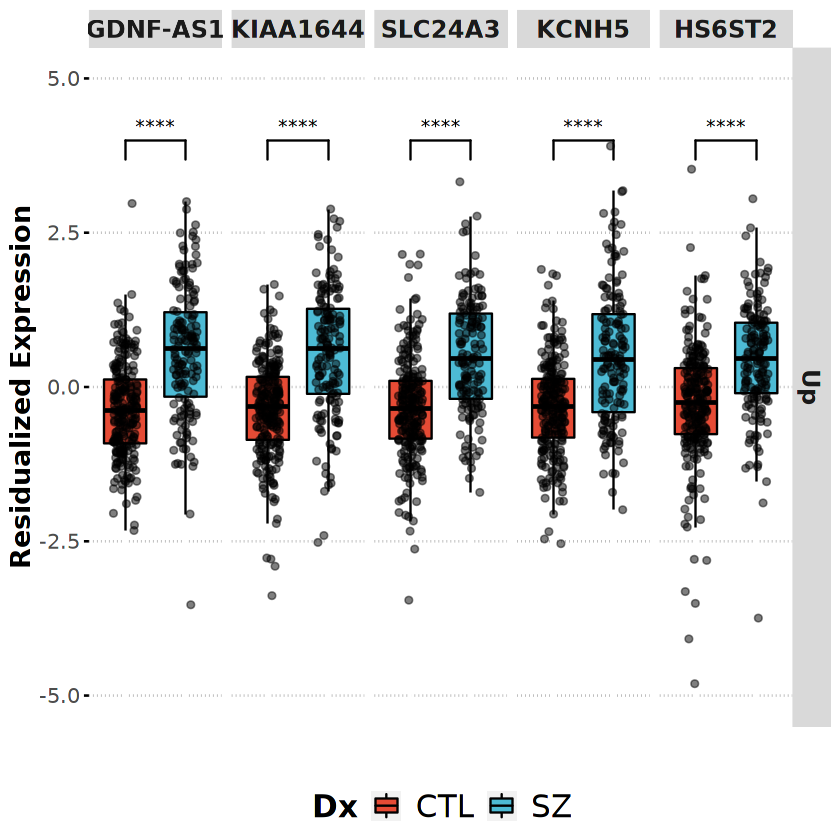

In [8]:
tmp = sig_genes %>% mutate(group1='CTL', group2='SZ', y_pos=4) %>% 
    filter(Direction == 'Up') %>%
    mutate_if(is.character, as.factor)

bxp_up <- df %>% filter(Direction=="Up") %>%
    ggboxplot(x="Dx", y="Res", facet.by=c("Direction", "New_ID"), fill="Dx", 
              xlab='', panel.labs.font=list(face='bold', size = 14), palette="npg", 
              outlier.shape=NA, ylab='Residualized Expression', add='jitter', 
              add.params=list(alpha=0.5), legend="bottom", ylim=c(-5, 5), 
              ggtheme=theme_pubclean()) +
    geom_signif(data=tmp, 
                aes(xmin=group1, xmax=group2, annotations=p.signif, 
                    y_position=y_pos), manual=TRUE) + 
    font("xy.text", size=12) + font("xy.title", size=16, face="bold") + 
    font("legend.title", size=18, face="bold") + 
    font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_up

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


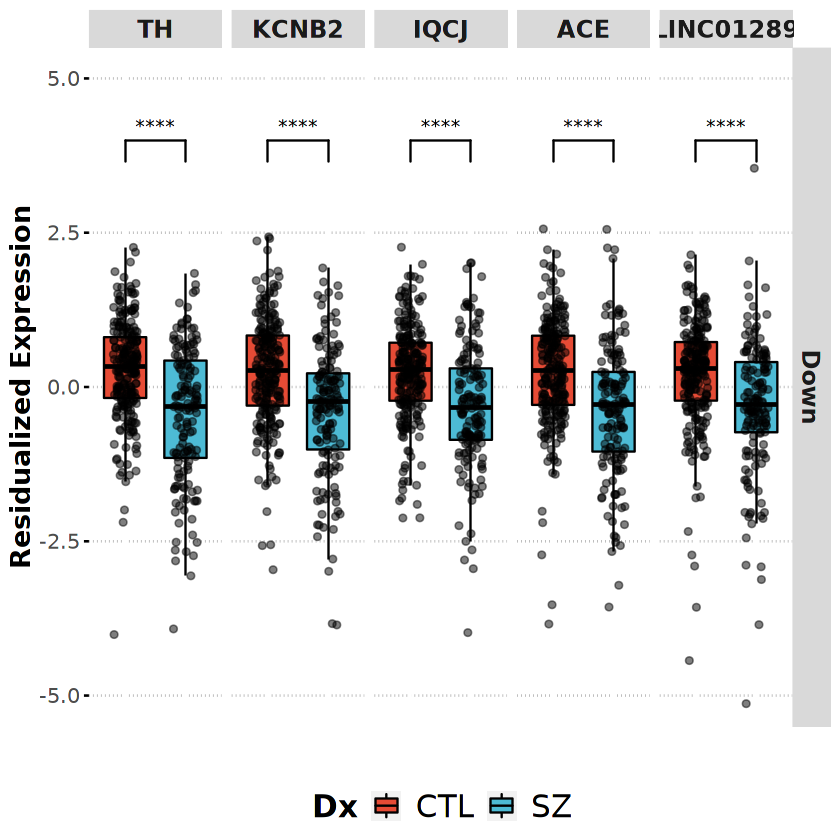

In [9]:
tmp = sig_genes %>% mutate(group1='CTL', group2='SZ', y_pos=4) %>% 
    filter(Direction == 'Down') %>%
    mutate_if(is.character, as.factor)

bxp_down <- df %>% filter(Direction=='Down') %>% 
    ggboxplot(x="Dx", y="Res", fill="Dx", palette="npg", xlab='', add="jitter",
              outlier.shape=NA, facet.by=c("Direction", "New_ID"), ylim=c(-5, 5),
              panel.labs.font=list(face='bold', size=14), legend="bottom", 
              add.params=list(alpha=0.5), ylab='Residualized Expression', 
              ggtheme=theme_pubclean()) +
    geom_signif(data=tmp, 
                aes(xmin=group1, xmax=group2, annotations=p.signif, 
                    y_position=y_pos), manual=TRUE) + 
    font("xy.text", size=12) + font("xy.title", size=16, face="bold") + 
    font("legend.title", size=18, face="bold") + 
    font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_down

### Annotate figure

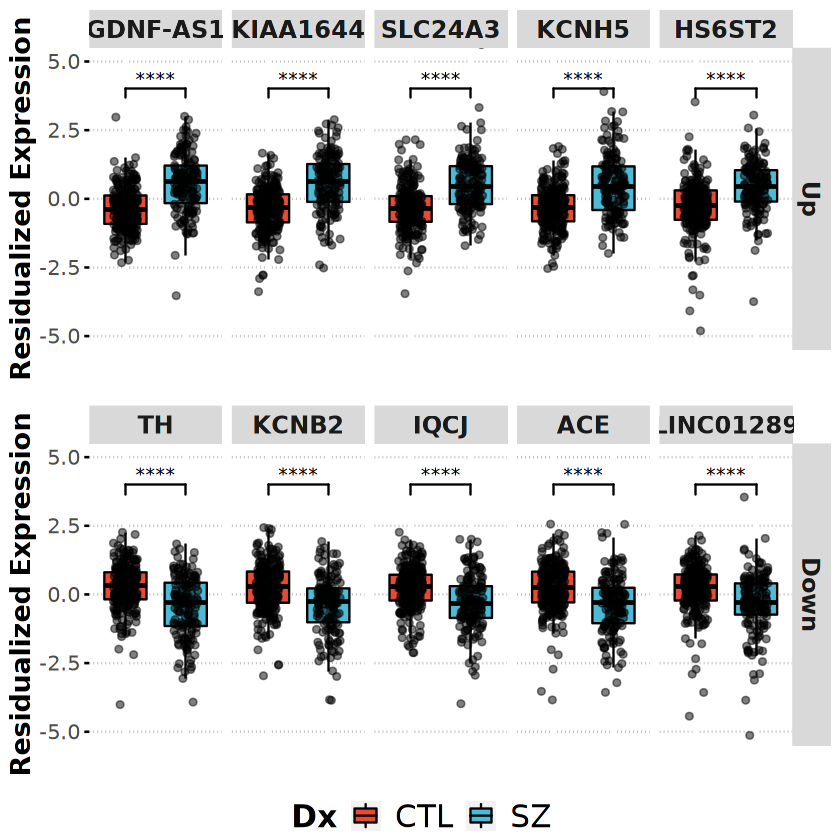

In [10]:
figure <- ggarrange(bxp_up, bxp_down, ncol=1, nrow=2, common.legend=TRUE, legend="bottom")
figure

In [11]:
save_ggplots('caudate_topSig_boxplot', figure, 10, 8)

## Session Info

In [12]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-07-09 14:53:31 EDT"

   user  system elapsed 
 10.894   1.645  12.726 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-07-09                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version  date       lib source        
 abind         1.4-5    2016-07-21 [1] CRAN (R 4.0.2)
 assertthat    0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports     1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc     0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 broom         0.7.8    2021-06-24 [1] CRAN (R 4.0.3)
 Cairo         1.5-12.2 2020-07-07 [1] CRAN (R 